In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from langdetect import detect_langs
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
def detect_language(text):
    langs = detect_langs(text)
    for lang in langs:
        if lang.lang in ['en', 'pt','tr','es'] and lang.prob >= 0.8:
            return True
    return False

In [5]:
def duplicate(row):
    if row['Subject'] == row['Customer Description']:
        return row['Subject']
    return row['Subject'] + ' ' + row['Customer Description']

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# Load data
data = pd.read_excel('Tagged tickets - until 20230705 - routers-2023-07-13-17-06-19.xlsx')
data['Subject'].fillna(data['Subject'].mode()[0], inplace=True)
data['Customer Description'].fillna(data['Customer Description'].mode()[0], inplace=True)

In [8]:
X = data[['Subject', 'Customer Description']]
y = data['Tag: Issue Details']

In [9]:
# Metin verilerini vektörleme
vectorizer = TfidfVectorizer(stop_words=['english', 'portuguese', 'spanish', 'turkish'])
combined_text = X['Subject'] + ' ' + X['Customer Description']
X_tfidf = vectorizer.fit_transform(combined_text)

In [10]:
# Feature selection
selector = SelectKBest(chi2, k=1000)
X_selected = selector.fit_transform(X_tfidf, y)

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=50)

In [12]:
# Initialize and train the classifier
classifier = RandomForestClassifier(class_weight='balanced', n_estimators=1000, max_depth=None)
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [13]:
# Make predictions on the test set
y_pred_test = classifier.predict(X_test)

In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='weighted')

In [15]:
print("Accuracy statistics for the subset of data:")
print("Accuracy rate: {:.2f}%".format(accuracy * 100))
print("F1 score on test set: {:.2f}".format(f1))

Accuracy statistics for the subset of data:
Accuracy rate: 81.19%
F1 score on test set: 0.79


In [16]:
# Calculate the ratio of correct predictions to total predictions
correct_predictions = accuracy * len(y_test)
total_predictions = len(y_test)
correct_ratio = correct_predictions / total_predictions

In [17]:
# Calculate the percentage and convert to 100-based ratio
correct_ratio_percentage = correct_ratio * 100
correct_ratio_100_based = int(correct_ratio_percentage)

In [18]:
# Print the accuracy percentage and correct prediction ratio
print("Doğru tahmin/oranı: {}/{}".format(int(correct_predictions), total_predictions))

Doğru tahmin/oranı: 1351/1664


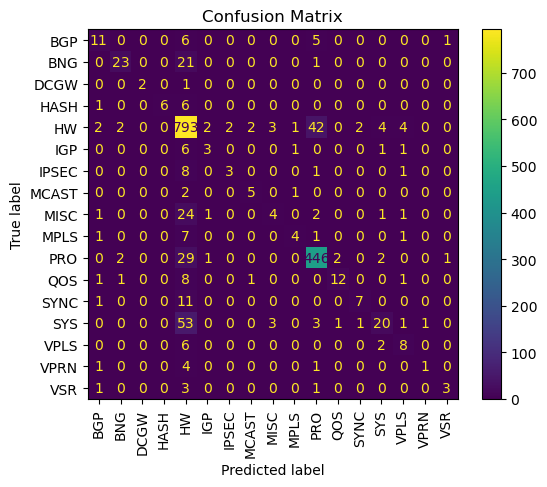

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

display_labels = np.unique(y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
cm_display.plot(cmap='viridis', include_values=True, ax=None, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [20]:
# Classification Report
print("\nClassification Report:")
print("------------------------------------------------------------------------")
print(classification_report(y_test, y_pred_test, zero_division=1))


Classification Report:
------------------------------------------------------------------------
              precision    recall  f1-score   support

         BGP       0.55      0.48      0.51        23
         BNG       0.82      0.51      0.63        45
        DCGW       1.00      0.67      0.80         3
        HASH       1.00      0.46      0.63        13
          HW       0.80      0.92      0.86       859
         IGP       0.43      0.25      0.32        12
       IPSEC       0.60      0.23      0.33        13
       MCAST       0.62      0.62      0.62         8
        MISC       0.40      0.12      0.18        34
        MPLS       0.57      0.29      0.38        14
         PRO       0.89      0.92      0.90       483
         QOS       0.80      0.50      0.62        24
        SYNC       0.70      0.37      0.48        19
         SYS       0.67      0.24      0.35        83
        VPLS       0.44      0.50      0.47        16
        VPRN       0.50      0.14     

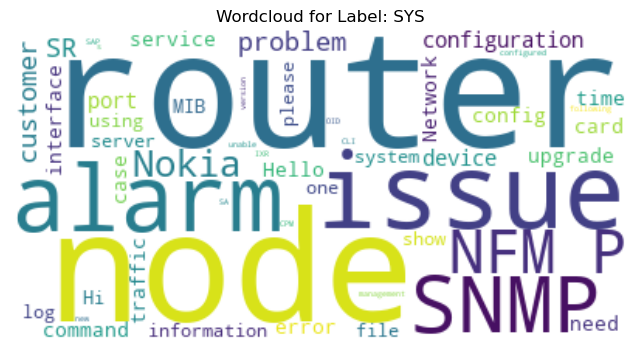

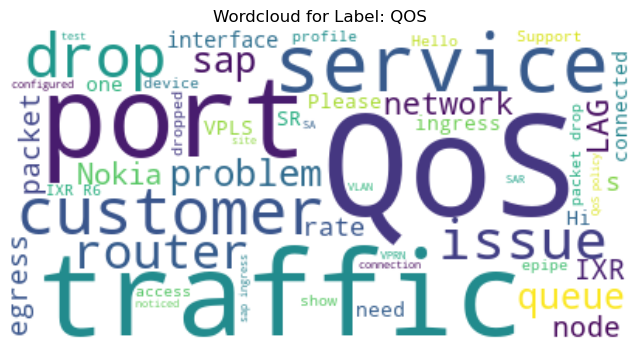

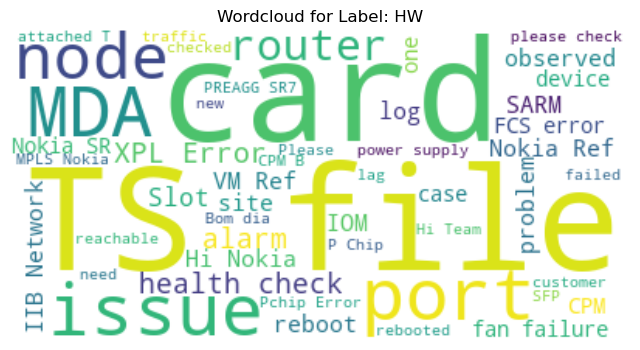

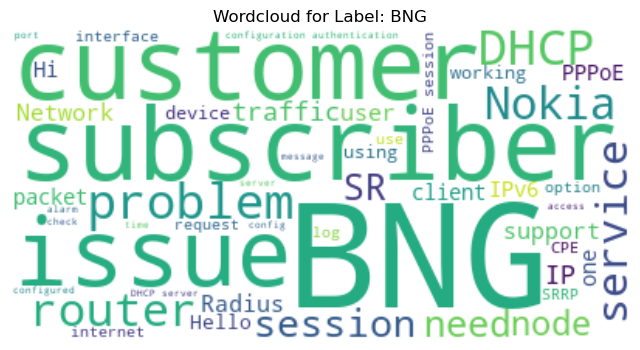

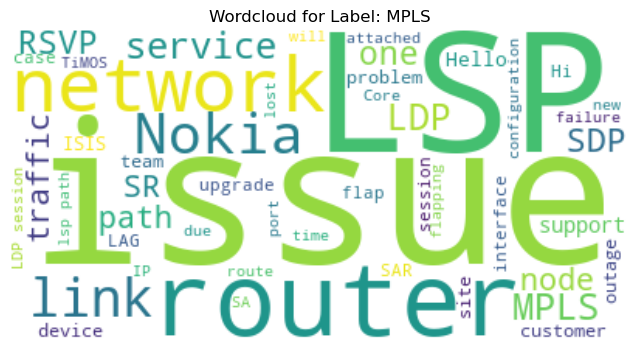

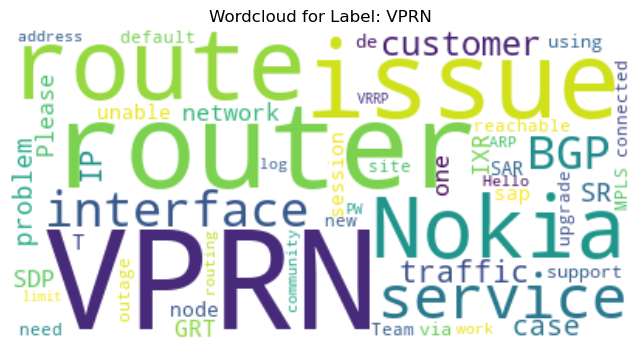

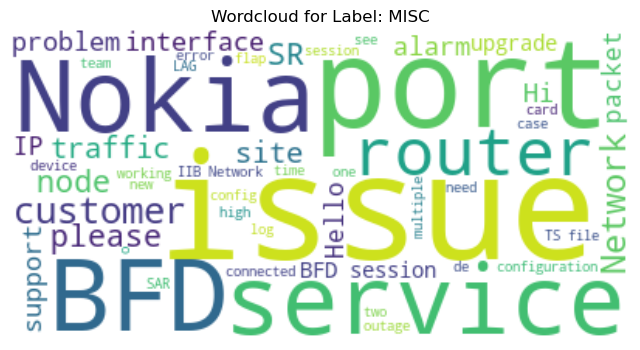

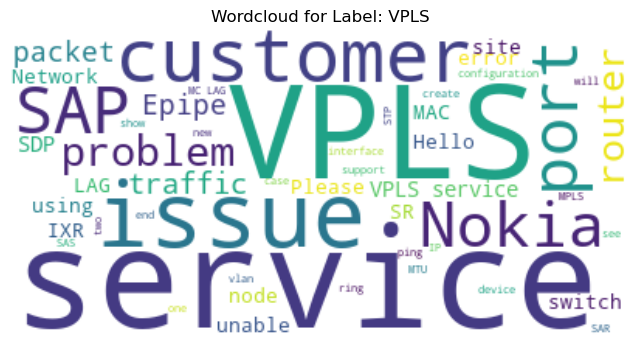

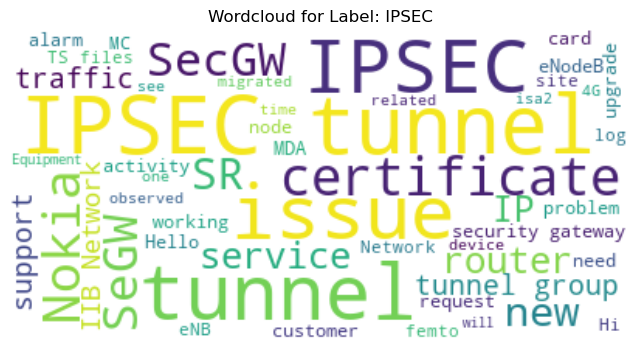

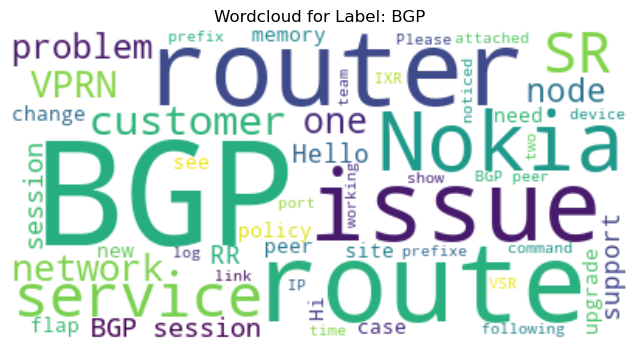

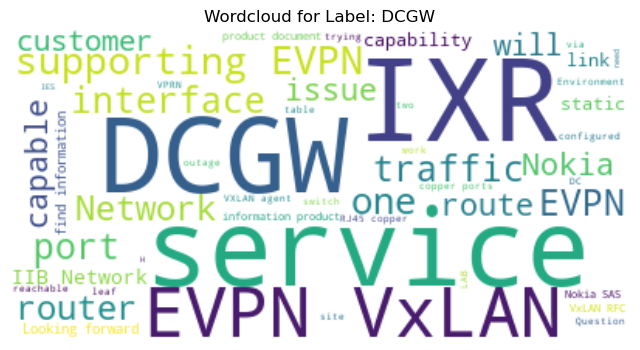

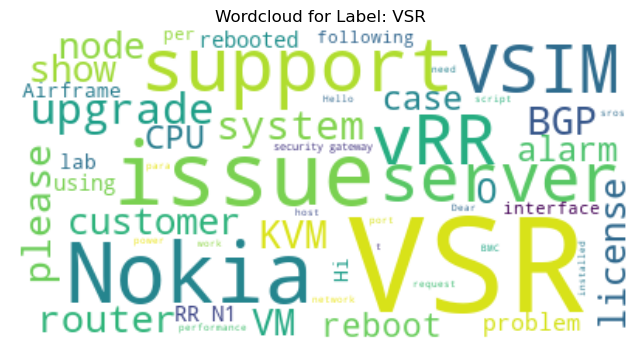

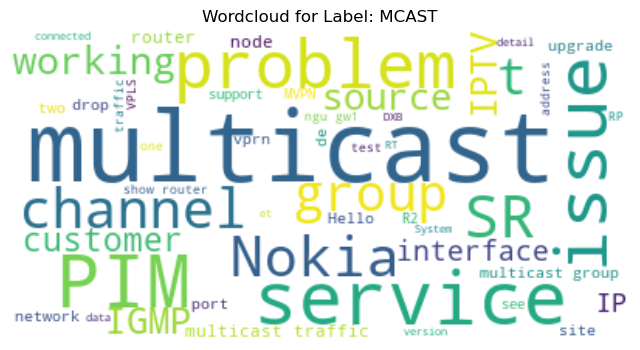

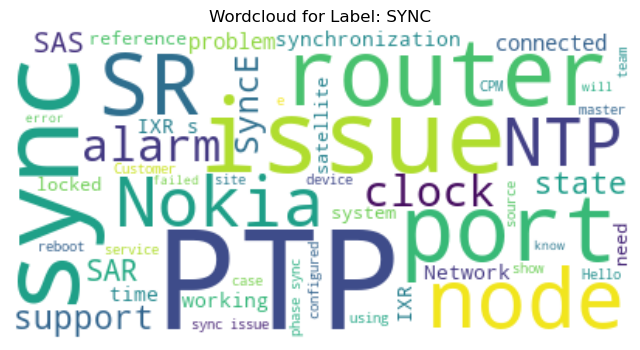

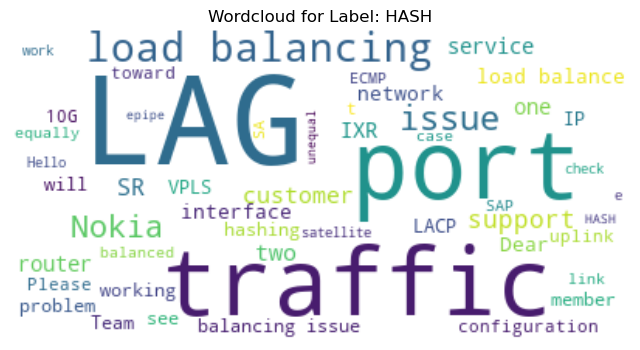

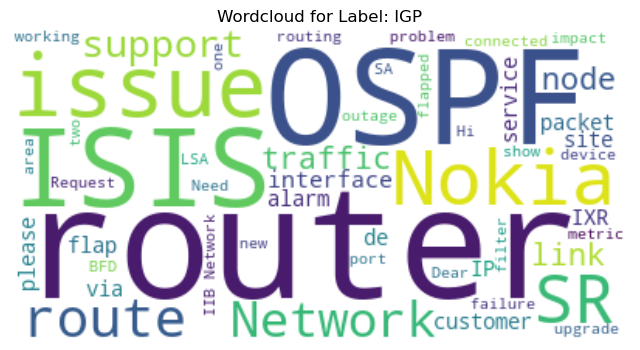

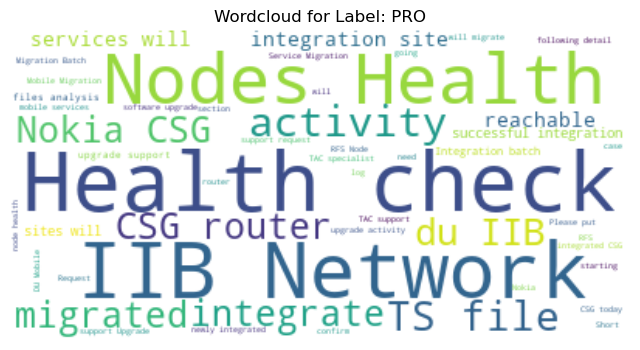

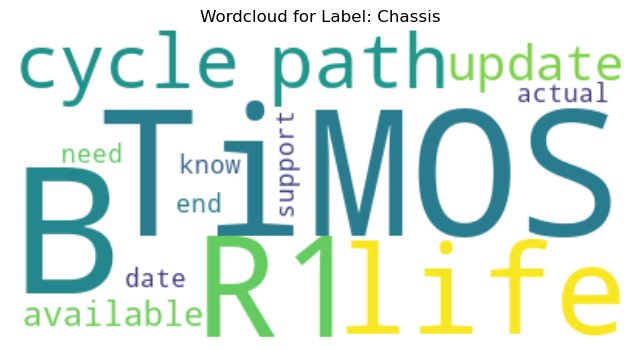

In [21]:
# Wordclouds for each label
for label in y.unique():
    text = ' '.join(X[y == label]['Subject'] + ' ' + X[y == label]['Customer Description'])
    stop_words = set(STOPWORDS)
    stop_words.update(["nan", "ticket", "description"])

    wordcloud = WordCloud(max_words=50, background_color='white', stopwords=stop_words)
    wordcloud.generate(text)

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Wordcloud for Label: {label}")
    plt.axis('off')
    plt.show()